In [1]:
import os

input_dir = "/kaggle/input/the-oxfordiiit-pet-dataset/images/images/"
target_dir = "/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps"
img_size = (80, 80)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:3], target_img_paths[:3]):
    print(input_path, "|", target_path)

Number of samples: 7390
/kaggle/input/the-oxfordiiit-pet-dataset/images/images/Abyssinian_1.jpg | /kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/Abyssinian_1.png
/kaggle/input/the-oxfordiiit-pet-dataset/images/images/Abyssinian_10.jpg | /kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/Abyssinian_10.png
/kaggle/input/the-oxfordiiit-pet-dataset/images/images/Abyssinian_100.jpg | /kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/trimaps/Abyssinian_100.png


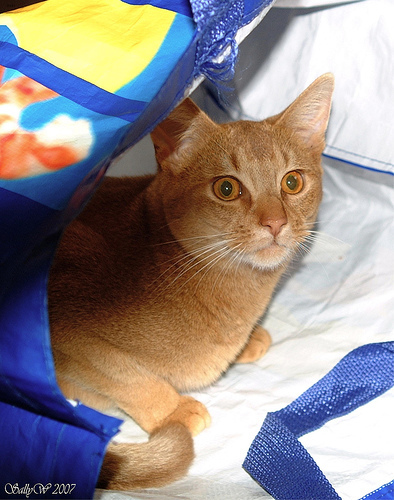

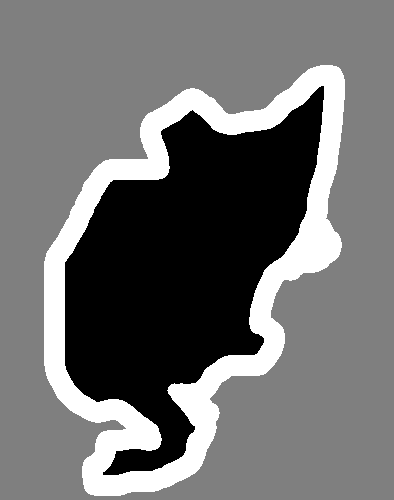

In [2]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #2
display(Image(filename=input_img_paths[2]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[2]))
display(img)

In [3]:
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPetsDataGenerator(utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # Filling in the feature image data
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            
            # loads in the image and resizes in the target size
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        # Filling in the label data
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        
        return x, y

In [4]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)

# Splitting data accoring to val_samples
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiating data generators for training and validation sets
train_gen = OxfordPetsDataGenerator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPetsDataGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [5]:
# Importing libraries and modules
import warnings
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

# Building the convolutional block
def ConvBlock(inputs, filters=8):

    conv1 = layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)
    
    return act1

# Building the encoder
def encoder(inputs, filters=8):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

# Building the decoder
def decoder(inputs, skip, filters=8):
    # Upsampling and concatenating the essential features
    Upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out

def get_U_Net(image_size):
    inputs = layers.Input(image_size)
    
    # Construct the encoder blocks and increasing the filters by a factor of 2
    skip1, encoder_1 = encoder(inputs, 8)
    skip2, encoder_2 = encoder(encoder_1, 8*2)
    
    # Preparing the next block
    conv_block = ConvBlock(encoder_2, 8*8)
    
    # Construct the decoder blocks and decreasing the filters by a factor of 2
    decoder_1 = decoder(conv_block, skip2, 8*8)
    decoder_2 = decoder(decoder_1, skip1, 8*4)
    
    outputs = layers.Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_2)
    
    model = models.Model(inputs, outputs)
    return model

In [6]:
input_shape = (80, 80, 3)
model = get_U_Net(input_shape)
model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy")
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 8)    224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 80, 80, 8)    0           ['batch_normalization[0][0]']

31/31 [==============================] - 9s 268ms/step


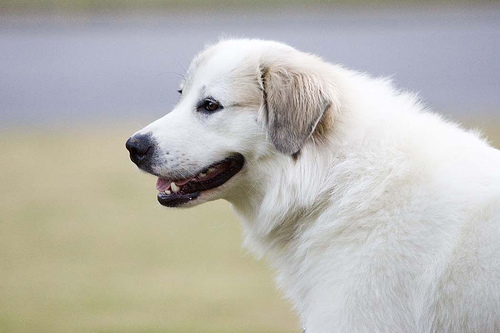

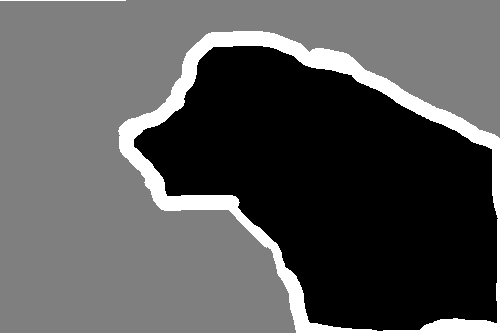

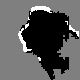

In [7]:
# Generate predictions for all images in the validation set

val_gen = OxfordPetsDataGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image idx 2
i = 2

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.